In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp

from sklearn.model_selection import learning_curve


# !apt-get install python-opengl -y

# !apt install xvfb -y

# !pip install pyvirtualdisplay

# !pip install piglet

# from pyvirtualdisplay import Display
# Display().start()

import gym
# from IPython import display
# import matplotlib.pyplot as plt
# %matplotlib inline

In [ ]:
# ! pip install swig 
# ! pip install box2d-py

! pip install box2d-py

     |████████████████████████████████| 448 kB 25.9 MB/s 


In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)

### Actor Critic

In [ ]:
class ActorCriticNetwork(keras.Model):
  def __init__(self,n_actions, fc1_dims=1024,fc2_dims=512, name='actor_critic', chkpt_dir='tmp/actor_critic'):
    super(ActorCriticNetwork, self).__init__()
    self.fc1_dims =fc1_dims
    self.fc2_dims =fc2_dims
    self.n_actions =n_actions
    self.model_name =name
    self.checkpoint_dir =chkpt_dir
    self.checkpoint_file=os.path.join(self.checkpoint_dir , name+'_ac')
    
    self.fc1 =Dense(self.fc1_dims, activation='relu')
    self.fc2 =Dense(self.fc1_dims, activation='relu')
    self.v =Dense(1, activation=None)
    self.pi =Dense(n_actions, activation='softmax')

  def call(self, state):
    value =self.fc1(state)
    value =self.fc2(value)

    v=self.v(value)
    pi=self.pi(value)

    return v, pi

In [ ]:

class Agent:
  def __init__(self, alpha=0.0003, gamma=0.99, n_actions=2):
    self.gamma =gamma
    self.n_actions =n_actions
    self.action =None
    self.action_space =[i for i in range(self.n_actions)]
    self.actor_critic =ActorCriticNetwork(n_actions =n_actions)
    self.actor_critic.compile(optimizer =Adam(learning_rate= alpha))

  def choose_action(self, observation):
    state =tensorflow.convert_to_tensor([observation])
    _, probs =self.actor_critic(state)

    action_probalities =tfp.distributions.Categorical(probs=probs)
    action=action_probalities.sample()
    self.action =action

    return action.numpy()[0]

  def save_models(self):
    print("--saving models--")
    self.actor_critic.save_weights(self.actor_critic.checkpoint_file)

  def load_models(self):
    print("--loading models--")
    self.actor_critic.load_weights(self.actor_critic.checkpoint_file)  

  def learn(self, state, reward, state_, done):
    state =tensorflow.convert_to_tensor([state], dtype=tensorflow.float32)
    state_ =tensorflow.convert_to_tensor([state_], dtype=tensorflow.float32)
    reward =tensorflow.convert_to_tensor([reward], dtype=tensorflow.float32)

    with tensorflow.GradientTape(persistent=True) as tape:
      state_value, probs =self.actor_critic(state)
      state_value_, _ =self.actor_critic(state_)
      state_value =tensorflow.squeeze(state_value)
      state_value_ =tensorflow.squeeze(state_value_)

      action_probs =tfp.distributions.Categorical(probs=probs)
      log_prob =action_probs.log_prob(self.action)

      delta =reward + self.gamma*state_value_*(1-int(done)) - state_value
      actor_loss = -log_prob *delta
      critic_loss =delta *2

      total_loss =actor_loss + critic_loss

    gradient =tape.gradient(total_loss, self.actor_critic.trainable_variables)
    self.actor_critic.optimizer.apply_gradients(zip(gradient, self.actor_critic.trainable_variables))
  

--saving models--
--saving models--
--saving models--
--saving models--
--saving models--
--saving models--
--saving models--
--saving models--


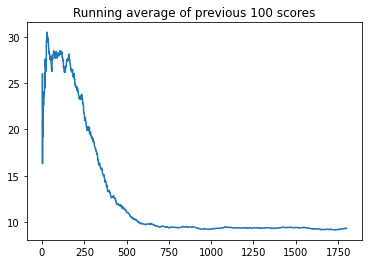

In [ ]:
if __name__ =='__main__':
  env = gym.make('CartPole-v0')
  agent= Agent(alpha=1e-5, n_actions=env.action_space.n)
  n_games =1800

  filename = 'cartploe.png'
  figure_file ='/content/tmp/' +filename

  best_score =env.reward_range[0]
  score_history =[]
  load_checkpoint =False
  
  if load_checkpoint:
    agent.load_model()

  for i in range(n_games):
    observation = env.reset()
    done =False
    score =0
    while not done:
      action =agent.choose_action(observation)
      observation_, reward, done, info =env.step(action)
      score +=reward

      if not load_checkpoint:
        agent.learn(observation, reward, observation_, done)
      observation =observation_
    score_history.append(score)
    avg_score =np.mean(score_history[-100:])

    if avg_score >best_score:
      best_score =avg_score
      if not load_checkpoint:
        agent.save_models()

  x =[i+1 for i in range(n_games)] 
  plot_learning_curve(x, score_history, figure_file)      


In [ ]:
# env = gym.make('CartPole-v0')
# env.reset()
# img = plt.imshow(env.render('rgb_array')) # only call this once
# for _ in range(40):
#     img.set_data(env.render('rgb_array')) # just update the data
#     display.display(plt.gcf())
#     display.clear_output(wait=True)
#     action = env.action_space.sample()
#     env.step(action)

### Deep Deterministic Policy Gradients (DDPG)

In [ ]:
class ReplayBuffer:
  def __init__(self, max_size, input_shape, n_actions):
    self.mem_size =max_size
    self.mem_cntr =0
    self.state_memory =np.zeros((self.mem_size, *input_shape))
    self.new_state_memory =np.zeros((self.mem_size, *input_shape))
    self.action_memory =np.zeros((self.mem_size, n_actions))
    self.reward_memory =np.zeros(self.mem_size)
    self.terminal_memory =np.zeros(self.mem_size, dtype=np.bool)

  def store_transition(self, state, action, reward, new_state, done):
    index =self.mem_cntr % self.mem_size

    self.state_memory[index] =state
    self.new_state_memory[index] =new_state
    self.action_memory[index] =action
    self.reward_memory[index] =reward
    self.terminal_memory[index] =done

    self.mem_cntr +=1

  def sample_buffer(self, batch_size):
    max_mem =min(self.mem_cntr, self.mem_size)
    batch =np.random.choice(max_mem, batch_size, replace=False)

    states =self.state_memory[batch]
    new_state =self.new_state_memory[batch]
    actions =self.action_memory[batch]
    rewards =self.reward_memory[batch]
    dones =self.terminal_memory[batch]

    return states, actions, rewards, new_state, dones

In [ ]:
class CriticNetwork(keras.Model):
    def __init__(self, fc1_dims=512, fc2_dims=512, name='critic', chkpt_dir='tmp/ddpg'):
        super(CriticNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims

        self.model_name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_ddpg.h5')

        self.fc1 = Dense(self.fc1_dims, activation='relu')
        self.fc2 = Dense(self.fc2_dims, activation='relu')
        self.q = Dense(1, activation=None)

    def call(self, state, action):
        action_value = self.fc1(tensorflow.concat([state, action], axis=1))
        action_value = self.fc2(action_value)

        q = self.q(action_value)

        return q

class ActorNetwork(keras.Model):
    def __init__(self, fc1_dims=512, fc2_dims=512, n_actions=2, name='actor', chkpt_dir='tmp/ddpg'):
        super(ActorNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions

        self.model_name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_ddpg.h5')

        self.fc1 = Dense(self.fc1_dims, activation='relu')
        self.fc2 = Dense(self.fc2_dims, activation='relu')
        self.mu = Dense(self.n_actions, activation='tanh')

    def call(self, state):
        prob = self.fc1(state)
        prob = self.fc2(prob)

        mu = self.mu(prob)

        return mu

In [ ]:
class Agent:
    def __init__(self, input_dims, alpha=0.001, beta=0.002, env=None,gamma=0.99, n_actions=2, max_size=1000000, tau=0.005,
                 fc1=400, fc2=300, batch_size=64, noise=0.1):
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size
        self.n_actions = n_actions
        self.noise = noise
        self.max_action = env.action_space.high[0]
        self.min_action = env.action_space.low[0]

        self.actor = ActorNetwork(n_actions=n_actions, name='actor')
        self.critic = CriticNetwork(name='critic')
        self.target_actor = ActorNetwork(n_actions=n_actions,name='target_actor')
        self.target_critic = CriticNetwork(name='target_critic')

        self.actor.compile(optimizer=Adam(learning_rate=alpha))
        self.critic.compile(optimizer=Adam(learning_rate=beta))
        self.target_actor.compile(optimizer=Adam(learning_rate=alpha))
        self.target_critic.compile(optimizer=Adam(learning_rate=beta))

        self.update_network_parameters(tau=1)

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        weights = []
        targets = self.target_actor.weights
        for i, weight in enumerate(self.actor.weights):
            weights.append(weight * tau + targets[i]*(1-tau))
        self.target_actor.set_weights(weights)

        weights = []
        targets = self.target_critic.weights
        for i, weight in enumerate(self.critic.weights):
            weights.append(weight * tau + targets[i]*(1-tau))
        self.target_critic.set_weights(weights)

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_weights(self.actor.checkpoint_file)
        self.target_actor.save_weights(self.target_actor.checkpoint_file)
        self.critic.save_weights(self.critic.checkpoint_file)
        self.target_critic.save_weights(self.target_critic.checkpoint_file)

    def load_models(self):
        print('... loading models ...')
        self.actor.load_weights(self.actor.checkpoint_file)
        self.target_actor.load_weights(self.target_actor.checkpoint_file)
        self.critic.load_weights(self.critic.checkpoint_file)
        self.target_critic.load_weights(self.target_critic.checkpoint_file)

    def choose_action(self, observation, evaluate=False):
        state = tensorflow.convert_to_tensor([observation], dtype=tensorflow.float32)
        actions = self.actor(state)
        if not evaluate:
            actions += tensorflow.random.normal(shape=[self.n_actions],
                                        mean=0.0, stddev=self.noise)
        # note that if the env has an action > 1, we have to multiply by
        # max action at some point
        actions = tensorflow.clip_by_value(actions, self.min_action, self.max_action)

        return actions[0]

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        state, action, reward, new_state, done = \
            self.memory.sample_buffer(self.batch_size)

        states = tensorflow.convert_to_tensor(state, dtype=tensorflow.float32)
        new_state = tensorflow.convert_to_tensor(new_state, dtype=tensorflow.float32)
        rewards = tensorflow.convert_to_tensor(reward, dtype=tensorflow.float32)
        actions = tensorflow.convert_to_tensor(action, dtype=tensorflow.float32)

        with tensorflow.GradientTape() as tape:
            target_actions = self.target_actor(new_state)
            critic_value_ = tensorflow.squeeze(self.target_critic(
                                new_state, target_actions), 1)
            critic_value = tensorflow.squeeze(self.critic(states, actions), 1)
            target = rewards + self.gamma*critic_value_*(1-done)
            critic_loss = keras.losses.MSE(target, critic_value)

        critic_network_gradient = tape.gradient(critic_loss,
                                                self.critic.trainable_variables)
        self.critic.optimizer.apply_gradients(zip(
            critic_network_gradient, self.critic.trainable_variables))

        with tensorflow.GradientTape() as tape:
            new_policy_actions = self.actor(states)
            actor_loss = -self.critic(states, new_policy_actions)
            actor_loss = tensorflow.math.reduce_mean(actor_loss)

        actor_network_gradient = tape.gradient(actor_loss,
                                               self.actor.trainable_variables)
        self.actor.optimizer.apply_gradients(zip(
            actor_network_gradient, self.actor.trainable_variables))

        self.update_network_parameters()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


... saving models ...
episode  0 score -1247.8 avg score -1247.8
episode  1 score -1790.2 avg score -1519.0
episode  2 score -1738.2 avg score -1592.1
episode  3 score -1755.9 avg score -1633.0
episode  4 score -1567.8 avg score -1620.0
episode  5 score -1109.3 avg score -1534.9
episode  6 score -1188.6 avg score -1485.4
episode  7 score -1383.2 avg score -1472.6
episode  8 score -1210.2 avg score -1443.5
episode  9 score -1172.0 avg score -1416.3
episode  10 score -1663.2 avg score -1438.8
episode  11 score -1190.2 avg score -1418.0
episode  12 score -1045.7 avg score -1389.4
episode  13 score -1031.6 avg score -1363.8
episode  14 score -1137.1 avg score -1348.7
episode  15 score -777.1 avg score -1313.0
episode  16 score -785.2 avg score -1282.0
episode  17 score -1108.8 avg score -1272.3
episode  18 score -1113.5 avg score -1264.0
episode  19 score -1038.6 avg score -1252.7
episode  20 score -1356.1 avg score -1257.6
... saving models ...
episode  21 score -890.5 avg score -1240.9
.

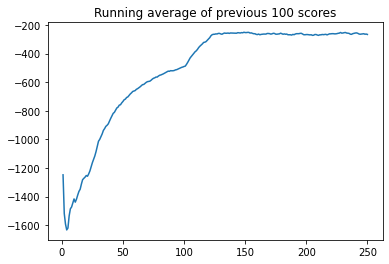

In [ ]:
if __name__ == '__main__':
    env = gym.make('Pendulum-v0')
    agent = Agent(input_dims=env.observation_space.shape, env=env,
            n_actions=env.action_space.shape[0])
    n_games = 250

    figure_file = '/content/tmp/pendulum.png'

    best_score = env.reward_range[0]
    score_history = []
    load_checkpoint = False

    if load_checkpoint:
        n_steps = 0
        while n_steps <= agent.batch_size:
            observation = env.reset()
            action = env.action_space.sample()
            observation_, reward, done, info = env.step(action)
            agent.remember(observation, action, reward, observation_, done)
            n_steps += 1
        agent.learn()
        agent.load_models()
        evaluate = True
    else:
        evaluate = False

    for i in range(n_games):
        observation = env.reset()
        done = False
        score = 0
        while not done:
            action = agent.choose_action(observation, evaluate)
            observation_, reward, done, info = env.step(action)
            score += reward
            agent.remember(observation, action, reward, observation_, done)
            if not load_checkpoint:
                agent.learn()
            observation = observation_

        score_history.append(score)
        avg_score = np.mean(score_history[-100:])

        if avg_score > best_score:
            best_score = avg_score
            if not load_checkpoint:
                agent.save_models()

        print('episode ', i, 'score %.1f' % score, 'avg score %.1f' % avg_score)

    if not load_checkpoint:
        x = [i+1 for i in range(n_games)]
        plot_learning_curve(x, score_history, figure_file)

### TD3 
TD3 stands for Twin Delayed DDPG

In [ ]:
class ReplayBuffer:
  def __init__(self, max_size, input_shape, n_actions):
    self.mem_size =max_size
    self.mem_cntr =0
    self.state_memory =np.zeros((self.mem_size, *input_shape))
    self.new_state_memory =np.zeros((self.mem_size, *input_shape))
    self.action_memory =np.zeros((self.mem_size, n_actions))
    self.reward_memory =np.zeros(self.mem_size)
    self.terminal_memory =np.zeros(self.mem_size, dtype=np.bool)

  def store_transition(self, state, action, reward, state_, done):
    index =self.mem_cntr % self.mem_size

    self.state_memory[index] =state
    self.new_state_memory[index] =state_
    self.action_memory[index] =action
    self.reward_memory[index] =reward
    self.terminal_memory[index] =done

    self.mem_cntr +=1

  def sample_buffer(self, batch_size):
    max_mem =min(self.mem_cntr, self.mem_size)
    batch =np.random.choice(max_mem, batch_size)

    states =self.state_memory[batch]
    new_state =self.new_state_memory[batch]
    actions =self.action_memory[batch]
    rewards =self.reward_memory[batch]
    dones =self.terminal_memory[batch]

    return states, actions, rewards, new_state, dones

In [ ]:
class CriticNetwork(keras.Model):
    def __init__(self, fc1_dims, fc2_dims, name, chkpt_dir='tmp/td3'):
        super(CriticNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.model_name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_td3')

        self.fc1 = Dense(self.fc1_dims, activation='relu')
        self.fc2 = Dense(self.fc2_dims, activation='relu')
        self.q = Dense(1, activation=None)

    def call(self, state, action):
        q1_action_value = self.fc1(tensorflow.concat([state, action], axis=1))
        q1_action_value = self.fc2(q1_action_value)

        q = self.q(q1_action_value)

        return q


class ActorNetwork(keras.Model):
    def __init__(self, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir='tmp/td3'):
        super(ActorNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.model_name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_td3')

        self.fc1 = Dense(self.fc1_dims, activation='relu')
        self.fc2 = Dense(self.fc2_dims, activation='relu')
        self.mu = Dense(self.n_actions, activation='tanh')

    def call(self, state):
        prob = self.fc1(state)
        prob = self.fc2(prob)

        mu = self.mu(prob)

        return 

In [ ]:
class Agent:
    def __init__(self, alpha, beta, input_dims, tau, env,
                 gamma=0.99, update_actor_interval=2, warmup=1000,
                 n_actions=2, max_size=1000000, layer1_size=400,
                 layer2_size=300, batch_size=100, noise=0.1):
        self.gamma = gamma
        self.tau = tau
        self.max_action = env.action_space.high[0]
        self.min_action = env.action_space.low[0]
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size
        self.learn_step_cntr = 0
        self.time_step = 0
        self.warmup = warmup
        self.n_actions = n_actions
        self.update_actor_iter = update_actor_interval

        self.actor = ActorNetwork(layer1_size, layer2_size,
                                  n_actions=n_actions, name='actor')

        self.critic_1 = CriticNetwork(layer1_size, layer2_size,
                                      name='critic_1')
        self.critic_2 = CriticNetwork(layer1_size, layer2_size,
                                      name='critic_2')

        self.target_actor = ActorNetwork(layer1_size, layer2_size,
                                         n_actions=n_actions,
                                         name='target_actor')
        self.target_critic_1 = CriticNetwork(layer1_size, layer2_size,
                                             name='target_critic_1')
        self.target_critic_2 = CriticNetwork(layer1_size, layer2_size,
                                             name='target_critic_2')

        self.actor.compile(optimizer=Adam(learning_rate=alpha), loss='mean')
        self.critic_1.compile(optimizer=Adam(learning_rate=beta),
                              loss='mean_squared_error')
        self.critic_2.compile(optimizer=Adam(learning_rate=beta),
                              loss='mean_squared_error')

        self.target_actor.compile(optimizer=Adam(learning_rate=alpha),
                                  loss='mean')
        self.target_critic_1.compile(optimizer=Adam(learning_rate=beta),
                                     loss='mean_squared_error')
        self.target_critic_2.compile(optimizer=Adam(learning_rate=beta),
                                     loss='mean_squared_error')

        self.noise = noise
        self.update_network_parameters(tau=1)

    def choose_action(self, observation):
        if self.time_step < self.warmup:
            mu = np.random.normal(scale=self.noise, size=(self.n_actions,))
        else:
            state = tf.convert_to_tensor([observation], dtype=tf.float32)
            # returns a batch size of 1, want a scalar array
            mu = self.actor(state)[0]
        mu_prime = mu + np.random.normal(scale=self.noise)

        mu_prime = tf.clip_by_value(mu_prime, self.min_action, self.max_action)
        self.time_step += 1

        return mu_prime

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        states, actions, rewards, new_states, dones = \
            self.memory.sample_buffer(self.batch_size)

        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        new_states = tf.convert_to_tensor(new_states, dtype=tf.float32)

        with tf.GradientTape(persistent=True) as tape:
            target_actions = self.target_actor(new_states)
            target_actions = target_actions + \
                tf.clip_by_value(np.random.normal(scale=0.2), -0.5, 0.5)

            target_actions = tf.clip_by_value(target_actions, self.min_action,
                                              self.max_action)

            q1_ = self.target_critic_1(new_states, target_actions)
            q2_ = self.target_critic_2(new_states, target_actions)

            q1 = tf.squeeze(self.critic_1(states, actions), 1)
            q2 = tf.squeeze(self.critic_2(states, actions), 1)

            # shape is [batch_size, 1], want to collapse to [batch_size]
            q1_ = tf.squeeze(q1_, 1)
            q2_ = tf.squeeze(q2_, 1)

            critic_value_ = tf.math.minimum(q1_, q2_)
            # in tf2 only integer scalar arrays can be used as indices
            # and eager exection doesn't support assignment, so we can't do
            # q1_[dones] = 0.0
            target = rewards + self.gamma*critic_value_*(1-dones)
            critic_1_loss = keras.losses.MSE(target, q1)
            critic_2_loss = keras.losses.MSE(target, q2)

        critic_1_gradient = tape.gradient(critic_1_loss,
                                          self.critic_1.trainable_variables)
        critic_2_gradient = tape.gradient(critic_2_loss,
                                          self.critic_2.trainable_variables)

        self.critic_1.optimizer.apply_gradients(
                   zip(critic_1_gradient, self.critic_1.trainable_variables))
        self.critic_2.optimizer.apply_gradients(
                   zip(critic_2_gradient, self.critic_2.trainable_variables))

        self.learn_step_cntr += 1

        if self.learn_step_cntr % self.update_actor_iter != 0:
            return

        with tf.GradientTape() as tape:
            new_actions = self.actor(states)
            critic_1_value = self.critic_1(states, new_actions)
            actor_loss = -tf.math.reduce_mean(critic_1_value)

        actor_gradient = tape.gradient(actor_loss,
                                       self.actor.trainable_variables)
        self.actor.optimizer.apply_gradients(
                        zip(actor_gradient, self.actor.trainable_variables))

        self.update_network_parameters()

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        weights = []
        targets = self.target_actor.weights
        for i, weight in enumerate(self.actor.weights):
            weights.append(weight * tau + targets[i]*(1-tau))

        self.target_actor.set_weights(weights)

        weights = []
        targets = self.target_critic_1.weights
        for i, weight in enumerate(self.critic_1.weights):
            weights.append(weight * tau + targets[i]*(1-tau))

        self.target_critic_1.set_weights(weights)

        weights = []
        targets = self.target_critic_2.weights
        for i, weight in enumerate(self.critic_2.weights):
            weights.append(weight * tau + targets[i]*(1-tau))

        self.target_critic_2.set_weights(weights)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_weights(self.actor.checkpoint_file)
        self.critic_1.save_weights(self.critic_1.checkpoint_file)
        self.critic_2.save_weights(self.critic_2.checkpoint_file)
        self.target_actor.save_weights(self.target_actor.checkpoint_file)
        self.target_critic_1.save_weights(self.target_critic_1.checkpoint_file)
        self.target_critic_2.save_weights(self.target_critic_2.checkpoint_file)

    def load_models(self):
        print('... loading models ...')
        self.actor.load_weights(self.actor.checkpoint_file)
        self.critic_1.load_weights(self.critic_1.checkpoint_file)
        self.critic_2.load_weights(self.critic_2.checkpoint_file)
        self.target_actor.load_weights(self.target_actor.checkpoint_file)
        self.target_critic_1.load_weights(self.target_critic_1.checkpoint_file)
        self.target_critic_2.load_weights(self.target_critic_2.checkpoint_file)

In [ ]:
if __name__ == '__main__':
  env = gym.make('BipedalWalker-v3')
  agent = Agent(alpha=0.001, beta=0.001,
          input_dims=env.observation_space.shape, tau=0.005,
          env=env, batch_size=100, layer1_size=400, layer2_size=300,
          n_actions=env.action_space.shape[0])
  n_games = 1000
  filename = 'tmp/td3' + 'walker_' + str(n_games) + '_games.png'

  best_score = env.reward_range[0]
  score_history = []

  #agent.load_models()

  for i in range(n_games):
      observation = env.reset()
      done = False
      score = 0
      while not done:
          action = agent.choose_action(observation)
          observation_, reward, done, info = env.step(action)
          agent.remember(observation, action, reward, observation_, done)
          agent.learn()
          score += reward
          observation = observation_
      score_history.append(score)
      avg_score = np.mean(score_history[-100:])

      if avg_score > best_score:
          best_score = avg_score
          agent.save_models()
      else:
        pass

      print('episode ', i, 'score %.1f' % score,
              'average score %.1f' % avg_score)

  x = [i+1 for i in range(n_games)]
  plot_learning_curve(x, score_history, filename)